In [ ]:
pip install pyts

In [ ]:
!pip install git+https://github.com/kieferk/pymssa.git

  Cloning https://github.com/kieferk/pymssa.git to /tmp/pip-req-build-1haopf3f
  Running command git clone --filter=blob:none --quiet https://github.com/kieferk/pymssa.git /tmp/pip-req-build-1haopf3f
  Resolved https://github.com/kieferk/pymssa.git to commit 9d4d3e2c317ef64d0604796cf3fbdf9b5dc8e7fe
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import random as rn
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization

# Fix seed for NumPy
np.random.seed(42)

# Fix seed for TensorFlow
tf.random.set_seed(42)

rn.seed(42)

tf.keras.utils.set_random_seed(42)

# Data generation and plot

In [ ]:
def make_sine_ts(n_points, start_time=0, dimension=1, n_periods=4, ampl=10):
    sigma = ampl / 10
    time = np.arange(1, n_points + 1)
    series_sine = ampl * np.sin(np.tile(time * (2 * np.pi * n_periods) / n_points + start_time, (dimension, 1)).T) + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((time, series_sine))
    columns = ['Time'] + [f'Sine_{i}' for i in range(1, dimension + 1)]
    ts = pd.DataFrame(table, columns=columns)
    return ts

In [ ]:
# generate synthetic time series
ts1 = make_sine_ts(200, dimension=1)
ts2 = make_sine_ts(200, dimension=1, n_periods=2)
ts3 = make_sine_ts(200, dimension=1, n_periods=1)
ts = ts1
ts['Sine_2'] = ts2.iloc[:, 1]
ts['Sine_3'] = ts3.iloc[:, 1]
ts

,Time,Sine_1,Sine_2,Sine_3
0,1.0,1.750046,0.985693,-1.280320
1,2.0,2.348635,1.814117,0.028530
2,3.0,4.328934,2.956864,0.946327
3,4.0,6.340567,3.540701,1.300313
4,5.0,5.643699,1.712501,1.114279
...,...,...,...,...
195,196.0,-4.432219,-2.956075,-1.763349
196,197.0,-4.565103,-3.586948,-1.210958
197,198.0,-2.333174,0.100540,-1.606669
198,199.0,-1.195124,-0.742445,-0.758401


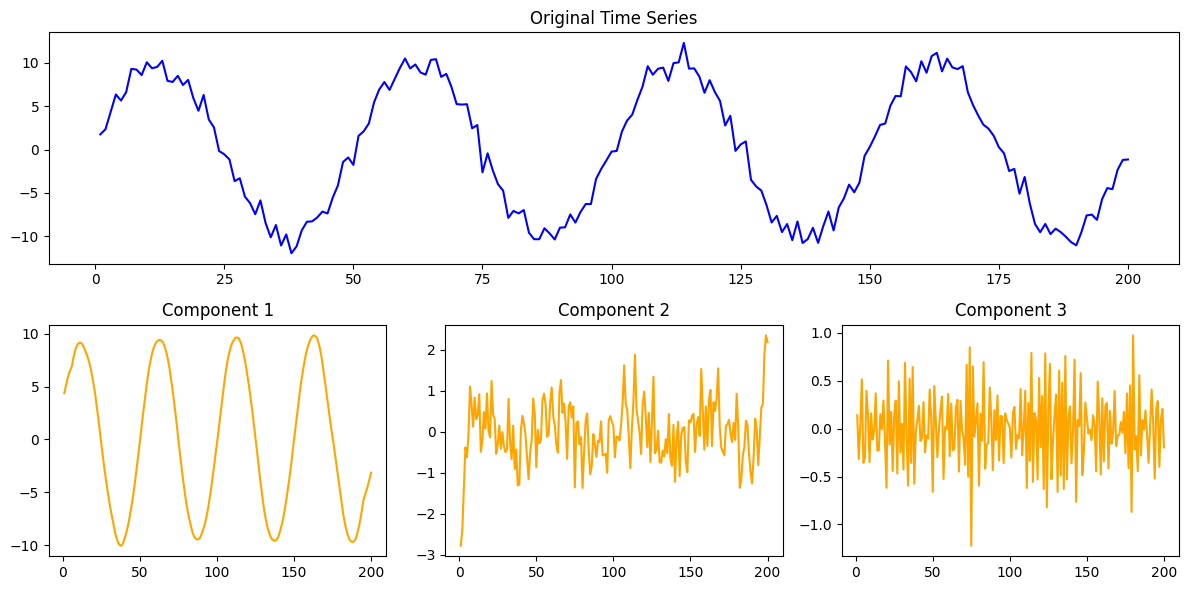

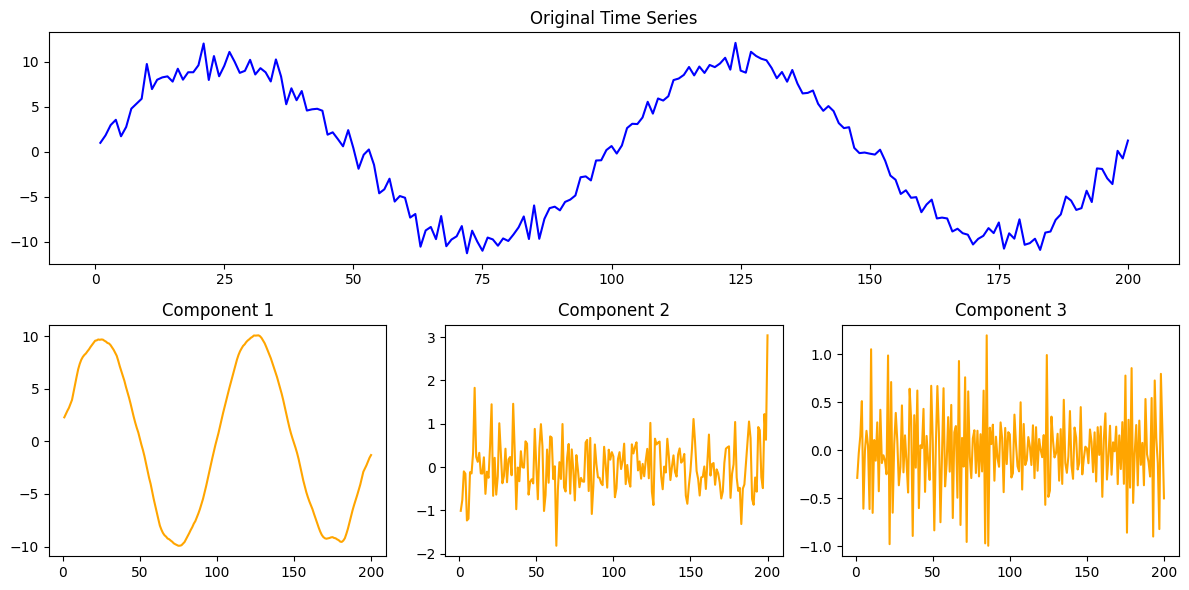

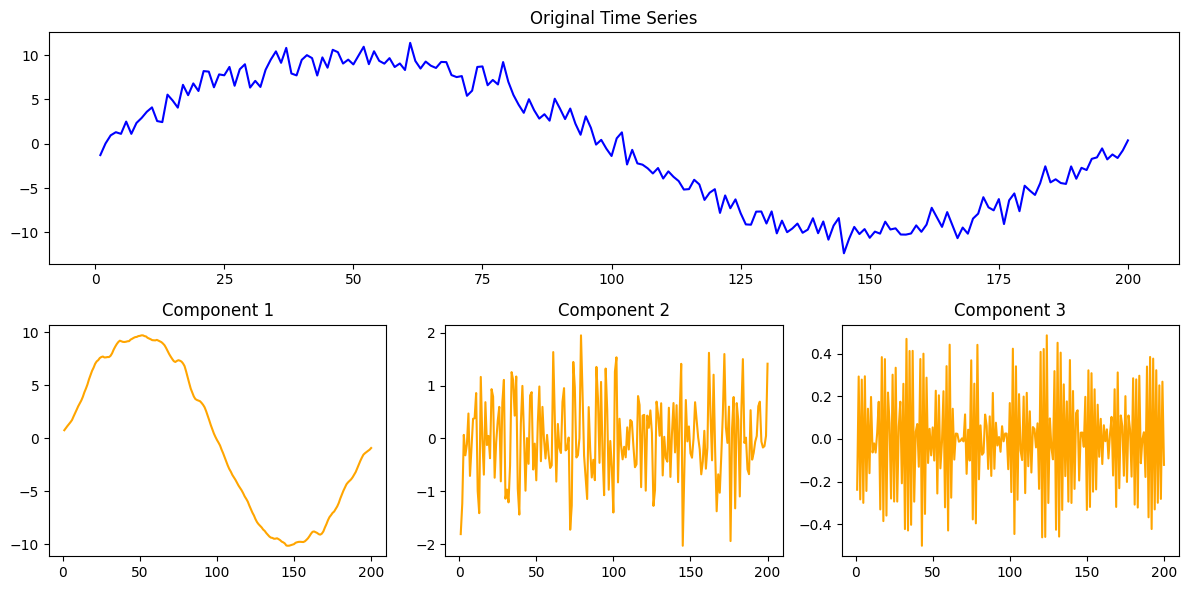

In [ ]:
from pyts.decomposition import SingularSpectrumAnalysis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Extract the values from the DataFrame
time_series_values = ts.iloc[:, 1:].values.T  # Exclude the 'Time' column

# Singular Spectrum Analysis
window_size = 6  # Adjust as needed
ssa = SingularSpectrumAnalysis(window_size=window_size, groups="auto")
components = ssa.fit_transform(time_series_values)

for graph_idx in range(0, time_series_values.shape[0]):
  # Plot the original time series and its components
  plt.figure(figsize=(12, 6))

  # Plot original time series
  plt.subplot(2, 1, 1)
  plt.plot(ts['Time'], time_series_values[graph_idx], label='Original Time Series', color='blue')
  plt.title('Original Time Series')

  # Plot SSA components
  for i in range(components.shape[1]):
      plt.subplot(2, components.shape[1], components.shape[1] + i + 1)
      plt.plot(ts['Time'], components[graph_idx, i, :], label=f'Component {i+1}', color='orange')
      plt.title(f'Component {i+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
time_series_values.shape

(3, 200)

#MSSA

In [ ]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from pymssa import MSSA

In [ ]:
def plot_forecast_complexity(mse, mape):
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # Adjust figsize as needed
    axs = axs.flatten()
    values = [mse, mape]
    labels = ["MSE", "MAPE"]
    for idx, ax in enumerate(axs):
        sum_of_k_best = [1/k*sum(sorted(values[idx])[:k]) for k in range(1, len(values[idx]) + 1)]

        ax.plot(range(1, len(values[idx]) + 1), sum_of_k_best, marker='o')
        ax.set_xlabel('k')
        ax.set_ylabel(f'Sum of k Best {labels[idx]}')
        ax.set_title(f'Sum of k Best {labels[idx]} Values for Predicted N Series')
        ax.grid(True)
        ax.invert_xaxis()

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

In [ ]:
def forecast_mssa(ts, tp, window_size, plot):
    ts_tr = ts.iloc[:-tp, :]
    tr_means = np.nanmean(ts_tr, axis=0)
    ts_tr = ts_tr - tr_means

    ts_te = ts.iloc[-tp:, :] - tr_means

    mssa = MSSA(n_components='parallel_analysis',
            pa_percentile_threshold=95,
            window_size=window_size,
            verbose=True)
    mssa.fit(ts_tr)

    time_series_c = ts.iloc[:, :] - tr_means

    series_mape = []
    series_mse = []

    fig, axs = plot #plt.subplots(3, 2, figsize=(12, 8))  # Adjust figsize as needed
    axs = axs.flatten()  # Flatten the 2D array for easy iteration

    for ts_index, (col, ax) in enumerate(zip(time_series_c.columns, axs)):
        tr = np.zeros(time_series_c.shape[0])
        tr[:] = np.nan

        te = np.copy(tr)

        tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
        fc = mssa.forecast(tp, timeseries_indices=ts_index)

        ytrue = ts_te.iloc[:, ts_index].values
        yhat = fc.ravel()[~pd.isnull(ytrue)]
        ytrue = ytrue[~pd.isnull(ytrue)]

        mape = mean_absolute_percentage_error(ytrue, yhat)
        mse = mean_squared_error(ytrue, yhat)

        series_mape.append(mape)
        series_mse.append(mse)

        te[-tp:] = fc

        ax.plot(time_series_c.index, time_series_c.iloc[:, ts_index].values + tr_means[ts_index], lw=3, alpha=0.2, c='k', label=time_series_c.columns[ts_index])
        # ax.plot(time_series_c.index, tr + tr_means[ts_index], lw=2, c='steelblue', alpha=0.75, label='Train')
        # ax.plot(time_series_c.index, te + tr_means[ts_index], lw=2, c='darkgoldenrod', label='Forecast')
        ax.plot(time_series_c.index, te + tr_means[ts_index], lw=2, c='darkgoldenrod', label=f'Forecast {time_series_c.columns[ts_index]}')
        # ax.set_xlabel("Time, h")
        # ax.set_ylabel("Energy Spot Price, EUR per MWh")
        ax.set_title('Forecast MAPE: {:.3f}, MSE: {:.3f}'.format(mape, mse))
        ax.legend()

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

    plot_forecast_complexity(series_mse, series_mape)

#MSSA Forecast of synthetic data

Constructing trajectory matrix
Trajectory matrix shape: (120, 101)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders


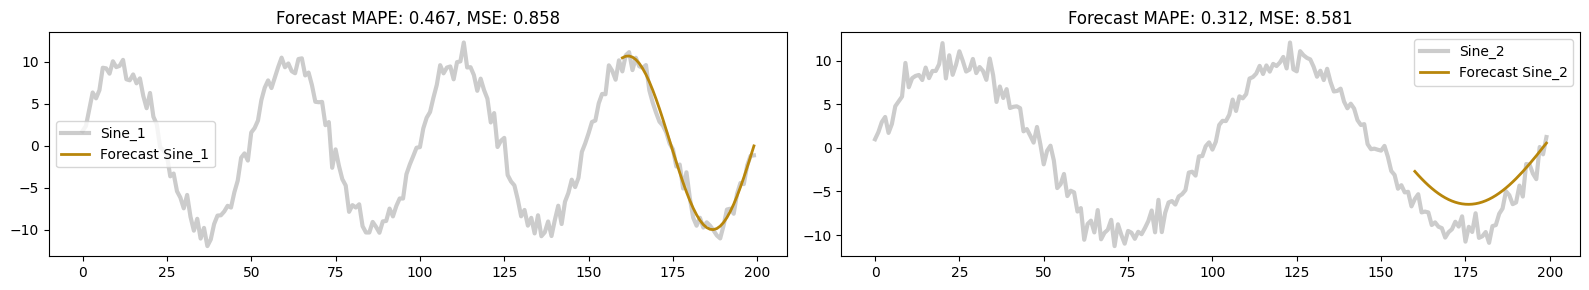

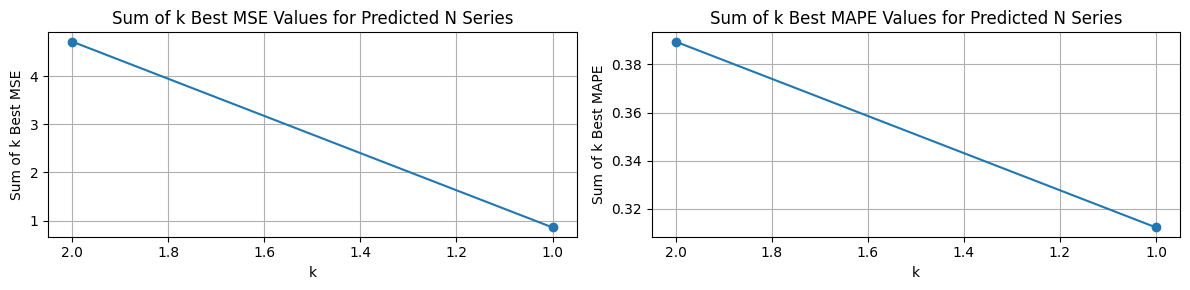

In [ ]:
forecast_mssa(ts.iloc[:, [1, 2]], 40, 60, plt.subplots(1, 2, figsize=(16, 3)))

Constructing trajectory matrix
Trajectory matrix shape: (60, 101)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders


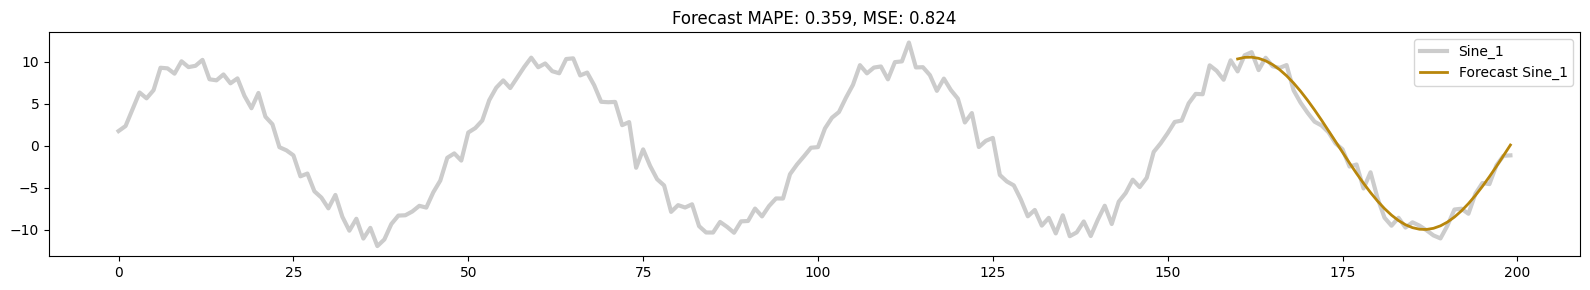

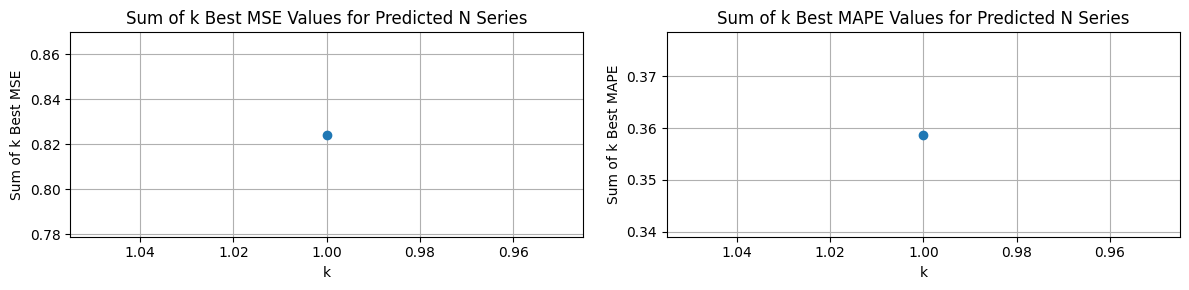

In [ ]:
forecast_mssa(ts.iloc[:, [1]], 40, 60, plt.subplots(1, 1, figsize=(16, 3), squeeze=False))

# MSSA forecast of Electricity spot dataset price hourly for the last years


In [ ]:
# electricity_ts = pd.read_csv("/content/Elspotprices.csv", delimiter=';', decimal=',')[:24*7][::-1]
# electricity_ts = electricity_ts.reset_index(drop=True)
# electricity_ts

Data preparation, create new columns for each year

In [ ]:
electricity = pd.read_csv("/content/Elspotprices.csv", delimiter=';', decimal=',')[::-1]
electricity = electricity.reset_index(drop=True)

# Convert to datetime
electricity['HourDK'] = pd.to_datetime(electricity['HourDK'])

df = pd.DataFrame()

# Create columns in the new DataFrame for each year and fill them with values
for year in electricity['HourDK'].dt.year.unique():
    year_data = electricity[electricity['HourDK'].dt.year == year]['SpotPriceEUR'].reset_index(drop=True)
    df[str(year)] = year_data

df

,2017,2018,2019,2020,2021,2022
0,20.959999,26.330000,28.320000,33.419998,50.869999,46.599998
1,20.900000,26.430000,10.070000,31.770000,48.189999,41.330002
2,18.129999,26.100000,-4.080000,31.570000,44.680000,42.180000
3,16.030001,24.700001,-9.910000,31.280001,42.919998,44.369999
4,16.430000,24.740000,-7.410000,30.850000,40.389999,37.669998
...,...,...,...,...,...,...
8755,26.840000,47.509998,33.849998,52.320000,48.009998,NaN
8756,25.940001,45.820000,33.540001,51.130001,33.959999,NaN
8757,25.340000,43.029999,33.169998,45.759998,33.080002,NaN
8758,25.680000,38.540001,33.040001,23.129999,32.340000,NaN


Text(0.5, 1.0, 'Корреляция')

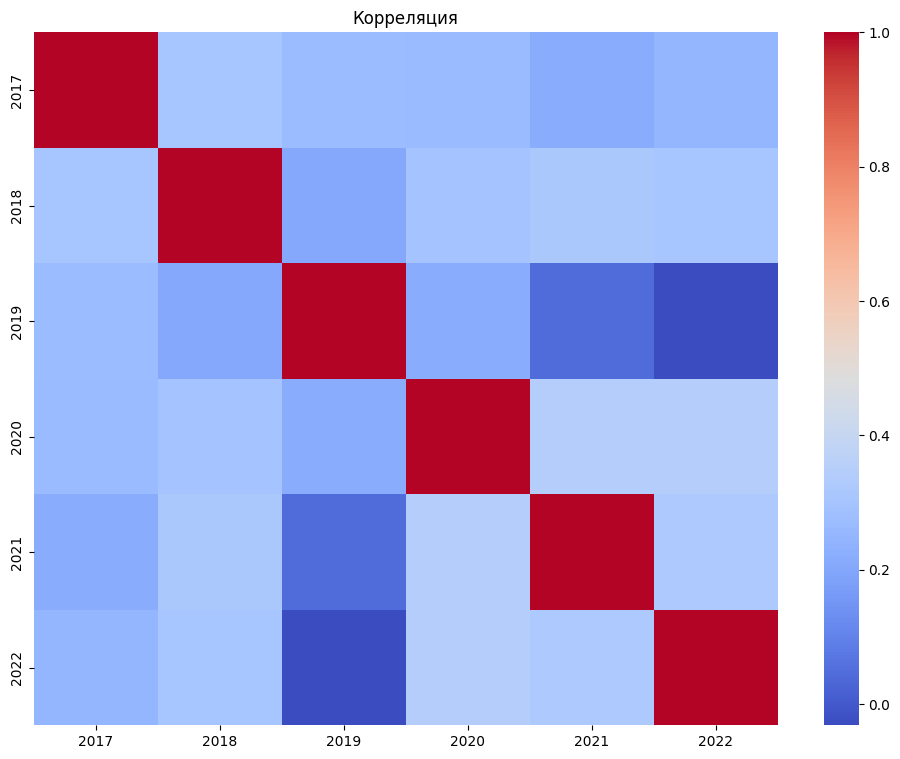

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(), cmap='coolwarm', ax=ax)
ax.set_title(f'Корреляция')

Constructing trajectory matrix
Trajectory matrix shape: (1008, 265)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 15
Constructing components
Calculating optimal reconstruction orders


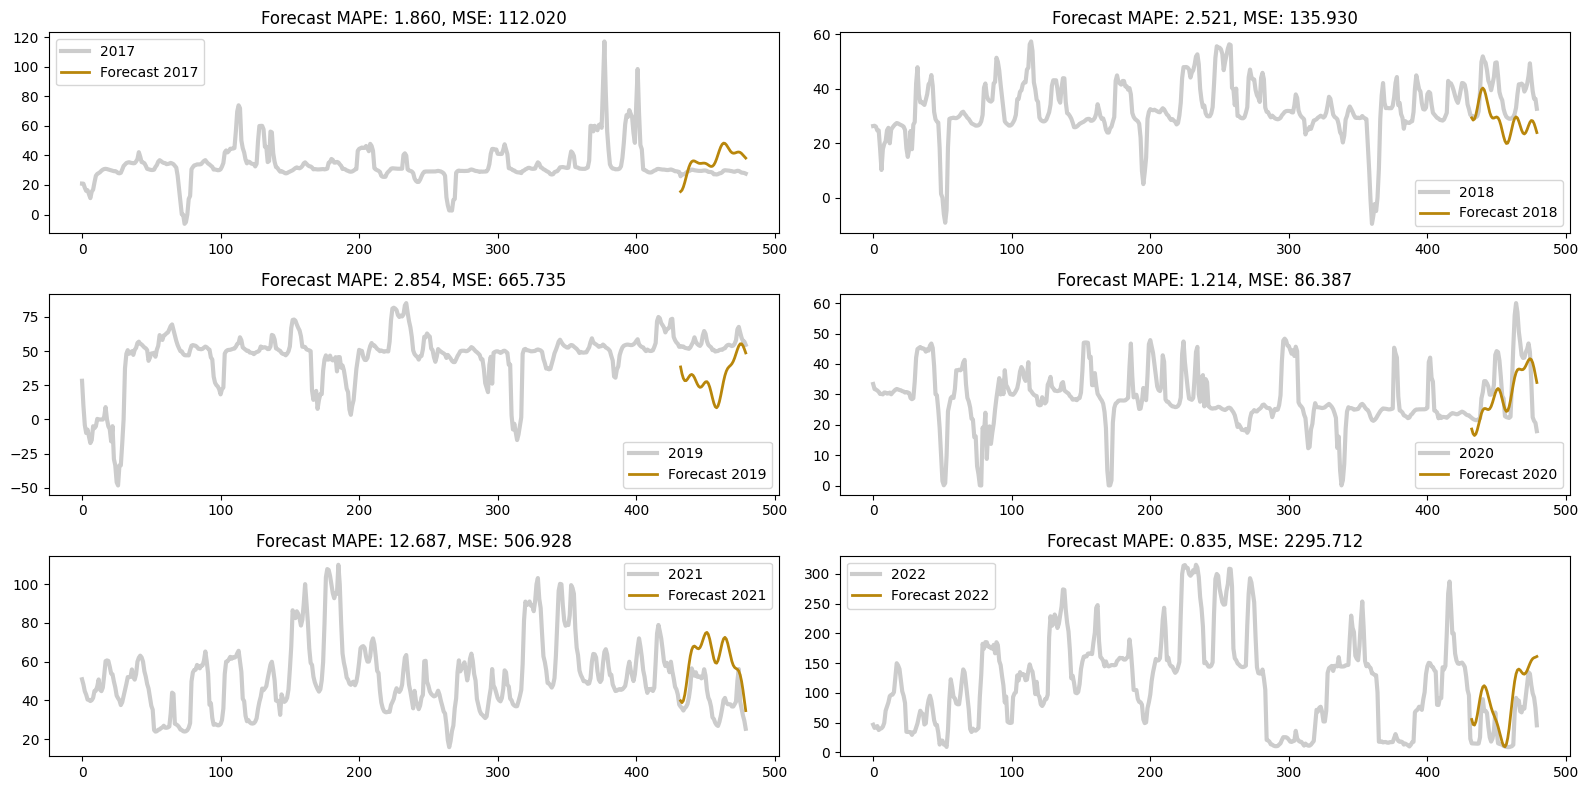

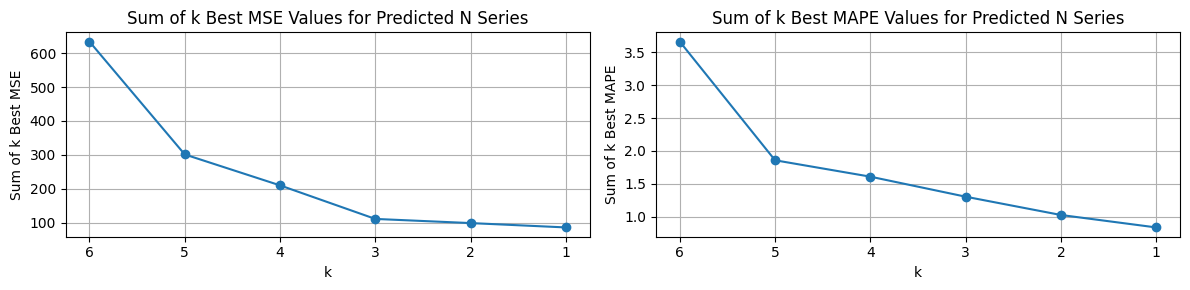

In [ ]:
forecast_mssa(df.iloc[:24*20, :], tp=24*2, window_size=24*7, plot=plt.subplots(3, 2, figsize=(16, 8)))

# LSTM

In [ ]:
def prepare_data(series, window_size):
    series = series.values
    X, y = [], []
    zeroes_array = np.zeros((window_size - 1, series.shape[1]))
    series = np.vstack((zeroes_array, series))

    for id in range(series.shape[1]):
        for i in range(series.shape[0]):
            end_ix = i + window_size
            if end_ix > len(series)-1:
                break
            seq_x, seq_y = series[i:end_ix, id], series[end_ix, id]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

def forecast(tp, model, x_input):
    fc = []
    for _ in range(tp):  # Predict next tp steps
        y_pred = model.predict(x_input.reshape((1, -1)), verbose=0)
        fc.append(y_pred[0])
        x_input = np.append(x_input[1:], y_pred[0])
    return np.array(fc)

def forecast_LSTM(ts, tp, window_size, plot):
    ts_tr = ts.iloc[:-tp, :]
    tr_means = np.nanmean(ts_tr, axis=0)
    ts_tr = ts_tr - tr_means

    ts_te = ts.iloc[-tp:, :] - tr_means

    # Build the LSTM Model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
        LSTM(100, activation='relu'),
        Dense(1)
    ])

    # Compile the Model
    model.compile(optimizer='adam', loss='mse')

    print(model.summary())

    # Prepare the data
    X, y = prepare_data(ts_tr, window_size)

    # Train the Model
    model.fit(X, y, epochs=200, verbose=0)

    time_series_c = ts.iloc[:, :] - tr_means

    fig, axs = plot #plt.subplots(3, 2, figsize=(12, 8))  # Adjust figsize as needed
    axs = axs.flatten()  # Flatten the 2D array for easy iteration

    series_mape = []
    series_mse = []

    for ts_index, (col, ax) in enumerate(zip(time_series_c.columns, axs)):
        tr = np.zeros(time_series_c.shape[0])
        tr[:] = np.nan

        te = np.copy(tr)

        X_idx, y_idx = prepare_data(ts_tr.iloc[:, [ts_index]], window_size)

        tr[1:-tp] = model.predict(X_idx, verbose=1).reshape((-1))

        fc = forecast(tp, model, ts_tr.iloc[-window_size:, ts_index].values)

        ytrue = ts_te.iloc[:, ts_index].values
        yhat = fc.ravel()[~pd.isnull(ytrue)]
        ytrue = ytrue[~pd.isnull(ytrue)]

        mape = mean_absolute_percentage_error(ytrue, yhat)
        mse = mean_squared_error(ytrue, yhat)

        series_mape.append(mape)
        series_mse.append(mse)

        te[-tp:] = fc.reshape(-1)

        ax.plot(time_series_c.index, time_series_c.iloc[:, ts_index].values + tr_means[ts_index], lw=3, alpha=0.2, c='k', label=time_series_c.columns[ts_index])
        # ax.plot(time_series_c.index, tr + tr_means[ts_index], lw=2, c='steelblue', alpha=0.75, label='Train')
        ax.plot(time_series_c.index, te + tr_means[ts_index], lw=2, c='darkgoldenrod', label='Forecast')
        # ax.set_xlabel("Time, h")
        # ax.set_ylabel("Energy Spot Price, EUR per MWh")
        ax.set_title('Forecast MAPE: {:.3f}, MSE: {:.3f}'.format(mape, mse))
        ax.legend()

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

# LSTM forecast of synthetic data

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
5/5 [==============================] - 1s 56ms/step


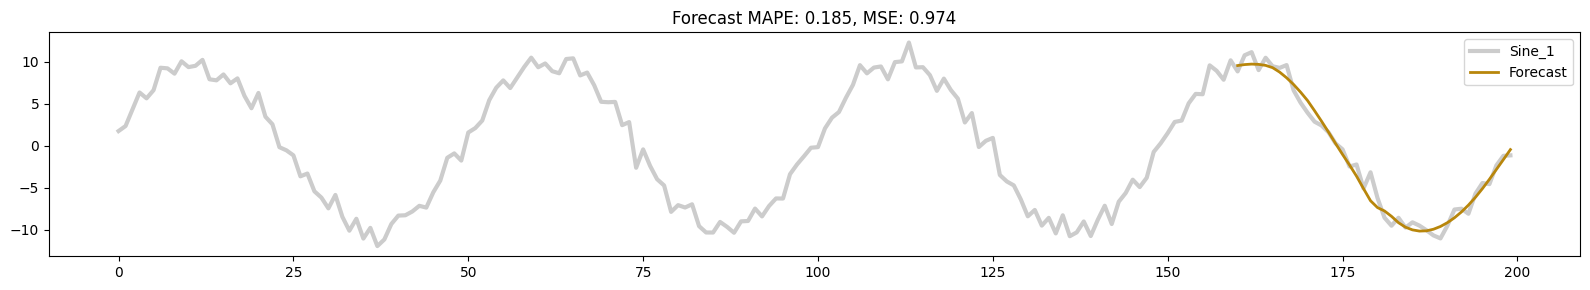

In [ ]:
forecast_LSTM(ts.iloc[:, [1]], tp=40, window_size=60, plot=plt.subplots(1, 1, figsize=(16, 3), squeeze=False))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
5/5 [==============================] - 0s 28ms/step


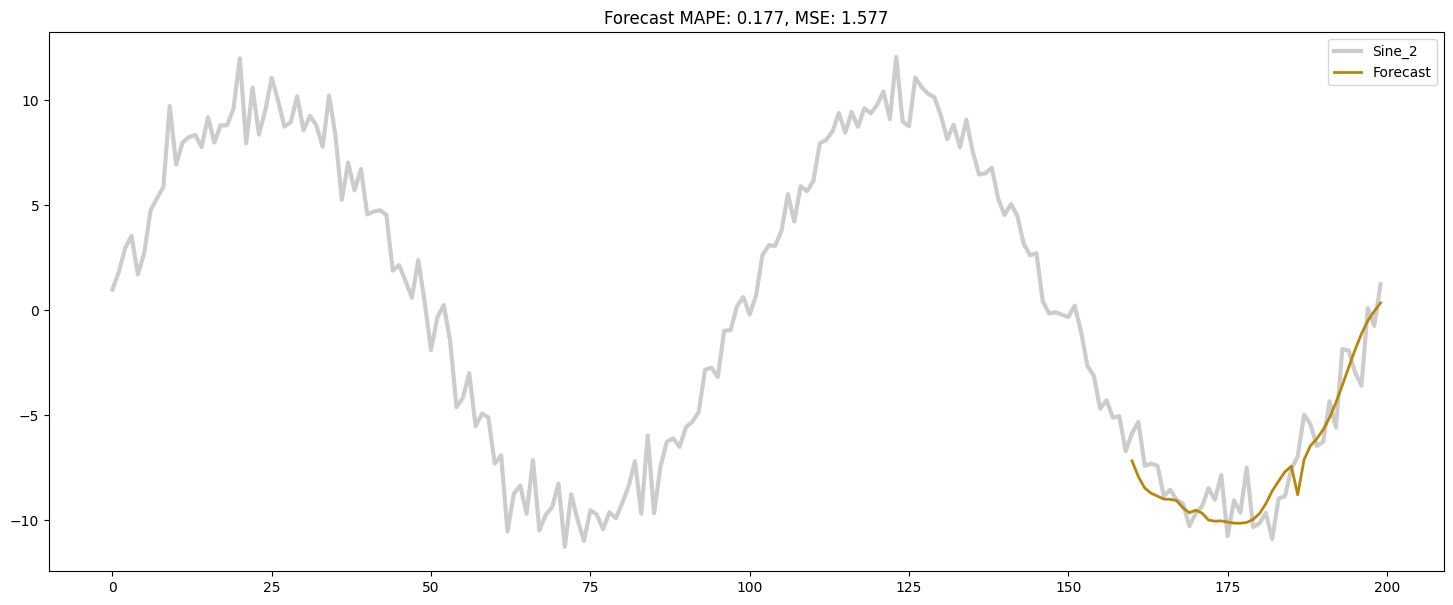

In [ ]:
forecast_LSTM(ts.iloc[:, [2]])

# LSTM & MSSA forecast of synthetic data with high noise

In [ ]:
# generate synthetic time series
ts1 = make_sine_ts(200, 1, ampl=40)
ts2 = make_sine_ts(200, 1, n_periods=2, ampl=40)
ts3 = make_sine_ts(200, 1, n_periods=1, ampl=40)
ts_high_ampl = ts1
ts_high_ampl['Sine_2'] = ts2.iloc[:, 1]
ts_high_ampl['Sine_3'] = ts3.iloc[:, 1]
ts_high_ampl

,Time,Sine_1,Sine_2,Sine_3
0,1.0,37.915520,33.911961,37.506576
1,2.0,41.284971,37.026851,34.641569
2,3.0,39.022336,35.151011,33.484848
3,4.0,34.711085,35.285998,31.569499
4,5.0,39.162511,36.166419,34.156853
...,...,...,...,...
195,196.0,18.339694,30.327600,36.528004
196,197.0,26.013285,29.268195,29.267919
197,198.0,30.805180,28.552678,28.190738
198,199.0,28.570140,28.096436,38.583278


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_33 (LSTM)              (None, 100)               80400     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
5/5 [==============================] - 0s 25ms/step


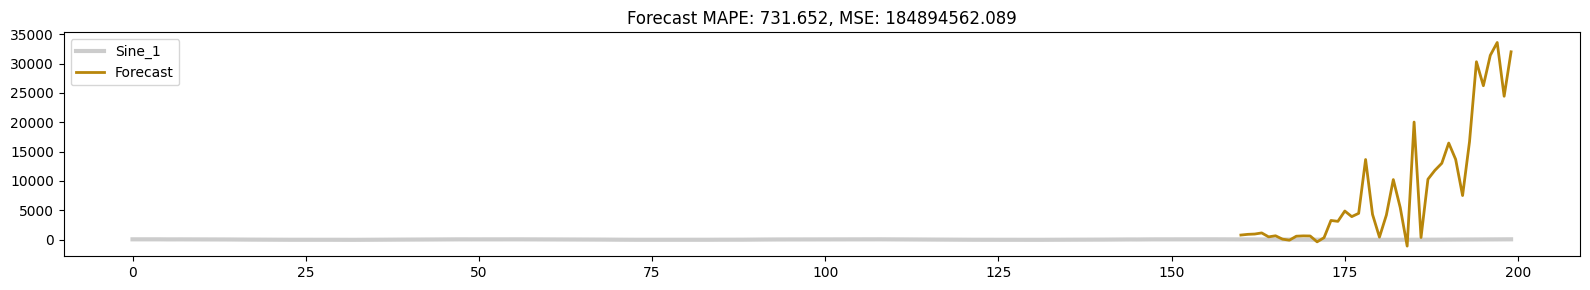

In [ ]:
forecast_LSTM(ts_high_ampl.iloc[:, [1]], tp=40, window_size=60, plot=plt.subplots(1, 1, figsize=(16, 3), squeeze=False))

Constructing trajectory matrix
Trajectory matrix shape: (120, 101)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders


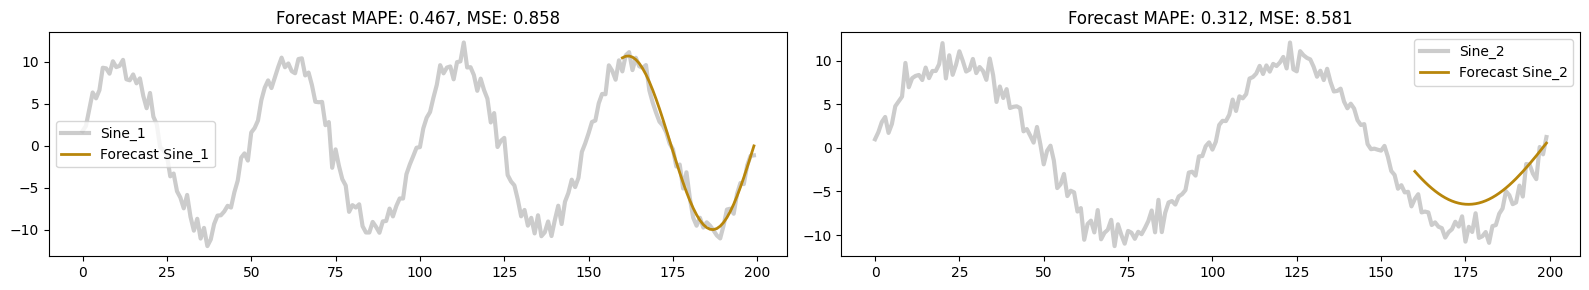

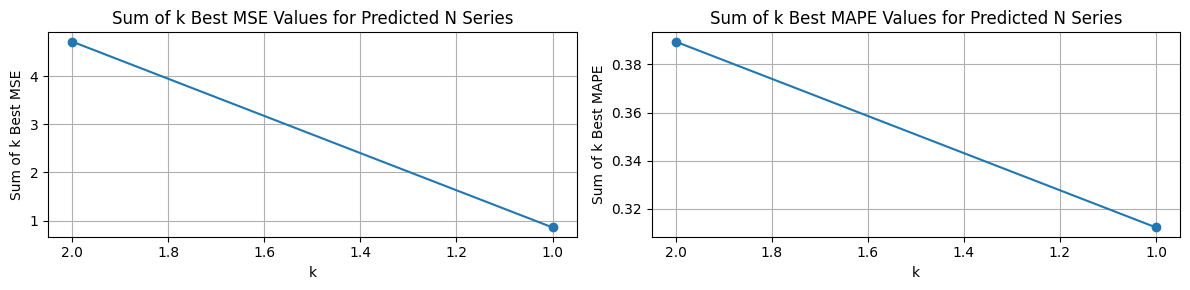

In [ ]:
forecast_mssa(ts.iloc[:, [1, 2]], 40, 60, plt.subplots(1, 2, figsize=(16, 3)))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is a DataFrame containing your time series
fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # Adjust figsize as needed
axs = axs.flatten()  # Flatten the 2D array for easy iteration

for i, (col, ax) in enumerate(zip(df.columns, axs)):
    ax.plot(df.index, df[col], label=col, color=f'C{i}')
    ax.set_title(col)
    ax.legend()

plt.tight_layout()  # Adjust subplot spacing
plt.show()

# LSTM forecast of Electricity spot dataset price hourly for the last years

In [ ]:
# forecast_LSTM(df.iloc[:24*20, [0]], tp=24*2, window_size=24*7)

# Forecast with new method (TODO: recovery to original space)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
from scipy.linalg import hankel
from sklearn.covariance import LedoitWolf

In [ ]:
time_series_data = ts.iloc[:, 1:]
time_series_data

In [ ]:
time_series_data.shape

In [ ]:
window_size

In [ ]:
def create_hankel_matrix(time_series, window_size):
    hankel_matrix = hankel(time_series[:-window_size+1], time_series[-window_size:])
    return hankel_matrix

In [ ]:
def calculate_distance_matrix(matrices):
    # Check if the matrices have the same number of vectors

    distances_matrix = np.zeros((matrices.shape[1], matrices.shape[0], matrices.shape[0]))

    # Iterate through the vectors in the matrices
    for i in range(matrices.shape[0]):
        for j in range(matrices.shape[0]):
            for t in range(matrices.shape[1]):
                distance = np.linalg.norm(matrices[i, t, :].T @ matrices[j, t, :])
                distances_matrix[t, i, j] = distance
    return distances_matrix

In [ ]:
def reshape_to_2d(matrix):
    return matrix.reshape(matrix.shape[0], -1)

def reshape_to_3d(matrix, num):
    return matrix.reshape(matrix.shape[0], num, -1)

In [ ]:
def get_distance_matrix(time_series, window_size=6):
    matrices = np.stack([create_hankel_matrix(time_series.iloc[:, i], window_size) for i in range(time_series.shape[1])])
    distances = calculate_distance_matrix(matrices)
    return distances

In [ ]:
distances = get_distance_matrix(time_series_data)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reshape_to_2d(distances[:-1]), reshape_to_2d(distances[1:]), test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

X_test.shape

In [ ]:
def predict(time_series, model):
    distances = get_distance_matrix(time_series)

    X_dist = reshape_to_2d(distances)

    y_dist = reshape_to_3d(model.predict(X_dist), distances.shape[1])

    y_pred = decoder(y_dist)

    return y_pred